In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy import stats
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
from cvxpy.atoms.norm_inf import norm_inf
import mosek
from scipy.stats import truncnorm

In [28]:
def prob_inv(K,m,n,c,Q,d,t,h,r):
    """Create the problem in cvxpy
    Parameters
    ----------
    K: int
        Number of data samples (clusters)
    -------
    The instance and parameters of the cvxpy problem
    """

    wk = cp.Parameter(K)
    eps = cp.Parameter()
    d_train = cp.Parameter((m,K))
    L = cp.Variable()
    st = cp.Variable(n)
    y = cp.Variable(n)
    Y = cp.Variable((n,m))

    s = cp.Variable(K)
    lam = cp.Variable()
    # 2n+1 gammas in total cause we have 2n+1 PWA defining the loss function
    gamma = cp.Variable((int(2*n+1), K*2*n))
    
    C = np.vstack([-np.eye(m), np.eye(m)])
    d_s = np.hstack([np.ones(m)*-1, np.ones(m)*3])

    objective = cp.Minimize(L)
    constraints = []
    constraints += [eps*lam + s@wk <= 0]
    # formulate constraints

    for k in range(K):
        constraints += [-r@y - r@Y@d_train[:,k] + (t+h)@st - L + gamma[0, (k*2*m):((k+1)*2*m)]@(d_s- C@d_train[:,k]) + cp.quad_over_lin(C.T@gamma[0, (k*2*m):((k+1)*2*m)] + r@Y,4*lam)  <= s[k]]
        for i in range(n):
            constraints += [y[i]+Y[i]@d_train[:,k] - st[i] + gamma[i+1, (k*2*m):((k+1)*2*m)]@(d_s- C@d_train[:,k]) + cp.quad_over_lin(C.T@gamma[i+1, (k*2*m):((k+1)*2*m)] - Y[i],4*lam)  <= s[k]]
            
            constraints += [y[i] - d[i]-(Q[i] - Y[i])@d_train[:,k] + gamma[i+n+1, (k*2*m):((k+1)*2*m)]@(d_s- C@d_train[:,k]) + cp.quad_over_lin(C.T@gamma[i+n+1, (k*2*m):((k+1)*2*m)] + (Q[i] - Y[i]),4*lam)<= s[k]]
        
    constraints += [lam >= 0]
    constraints += [np.ones(n)@st == C]
    constraints += [st <=c, st >=0]

    problem = cp.Problem(objective, constraints)

    return problem, y,Y,st, s, gamma, lam, d_train, wk, eps

In [29]:
def BoundedMultivariateNormalDist(means, cov_matrix, dimenions_bounds=None, size=1, rng=None):
    """Custom function: Draw random samples from a multivariate (truly multi-dimentional) normal (Gaussian) distribution, optionally set lower and upper bounds for the both dimentions of the distribution.
    
    Iteratively draws the needed number of samples and discards the samples outside the bounds until the requested sample size is reached.
    
        Parameters
    ----------
    means : ndarray of ints or floats
        means of the n distriburions
    cov_matrix  : 2d array (n by n) of ints or floats
        the covariance matrix of the n distributions
    dimenions_bounds: 2d (n by 2) array of ints or floats, optional
        rows are the dimensions, columns are the lower and upper bounds (in that order). Default is None (i.e unbounded). 
    size : (positive) int, optional
        nummber of samples to draw and return from the distribution. Default is 1. 


    Returns
    -------
    out : ndarray
        Array of samples from the multivariate normal distribution. If size is 1 (or not specified) a single array (of size n) is returned.
    
    """
    
    # convert arr_means and cov matrix to np.array
    means = np.array(means)
    cov_matrix = np.array(cov_matrix)
    # check if dimentions agree
    if not means.shape[0] == cov_matrix.shape[0]:
        raise ValueError("dimentions of means and cov matrix do not agree")
    if not cov_matrix.shape[0] == cov_matrix.shape[1]:
        raise ValueError("dimentions of means and cov matrix do not agree")

    ndims = means.shape[0]

    # if no dimenions_bounds if provided make a dimenions_bounds with np.nans
    if dimenions_bounds is None:
        dimenions_bounds = np.tile((np.nan),(ndims,2)) # make a ndims x 2 array of np.nan values
    
    
    # dimenions_bounds should be a (ndims x 2) 2d array where each row represents a dimention, 
    # and, where the first column (index=0) holds the lower bound 
    #     where the second colums (index=1) holds the upper bound
    if not dimenions_bounds.shape == (ndims,2):
        raise ValueError("dimentions of dimenions_bounds doesnt match the dimention of means")
    
    # define a local size
    local_size = size

    # create an empty array
    return_samples = np.empty([0,ndims])

    # generate new samples while the needed size is not reached
    while not return_samples.shape[0] == size:

        # get 'size' number of samples
        samples = np.random.default_rng().multivariate_normal(means, cov_matrix,size=local_size)

        # samples is n array of length n (as many as means, and as many as the side of the cov matrix)
        # we will stack the arrays of sample on top of each other,
        # so each row of retrun_samples is a set of n samples (each sample from one of each dimention)
        # each colums is the set of samples from one of the n dimentions

        # select only the samples that are within the upper and lower bounds for both dimentions

        # for the fist of the nd value (index = 0)

        # for each 'column' we check if the values are within the bounds of that respective column

        for dim, bounds in enumerate(dimenions_bounds):

            # keep only the samples that are bigger than the lower bound
            if not np.isnan(bounds[0]): # bounds[0] is the lower bound
                samples = samples[(samples[:,dim] > bounds[0])]  # samples[:,dim] is the column of the dim

            # keep only the samples that are smaller than the upper bound
            if not np.isnan(bounds[1]): # bounds[1] is the upper bound
                samples = samples[(samples[:,dim] < bounds[1])]   # samples[:,dim] is the column of the dim


        # input the samples into the retun samples
        return_samples = np.vstack([return_samples, samples])

        # get new size which is the difference between the requested size and the size so far.
        local_size = size - return_samples.shape[0]
    
    # return a single value when the requested size is 1 (or not specified)
    if return_samples.shape[0] == 1:
        return return_samples[0]
    # otherwise 
    else:
        return return_samples

In [30]:
# Create your array (replace with your actual data)

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def pairwise_distances(points):
    num_points = len(points)
    distances = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(i + 1, num_points):
            distances[i, j] = euclidean_distance(points[i], points[j])
            distances[j, i] = distances[i, j]  # Symmetric matrix
    return distances

def get_equidistant_points(a, b, K):
    # Calculate the distance between points
    distance_delta = ((b - a) / (K + 1))
    
    # Generate K equally spaced points
    points = [a + (i + 1) * distance_delta for i in range(K)]
    
    return points

In [31]:
def position_points(K, P):
    # Generate K equally spaced initial centroids
    d = 20/K
    a = np.linspace(d/2, 20-d/2, num=K, endpoint=True)
    #a = get_equidistant_points(0, 20, K)
    b = a.copy()

    mesh_a, mesh_b = np.meshgrid(a, b)
    combinations_matrix = np.column_stack((mesh_a.ravel(), mesh_b.ravel()))
  
    #distances = pairwise_distances(combinations_matrix)
    #distances[distances==0] = 10000
        
    #max_distance = np.max(distances)
    #rad = max_distance/2
    arr_1 = np.array([a[0],a[0]])
    arr_2 = np.array([a[1],a[1]])
    max_dist = np.linalg.norm(arr_2 - arr_1)
    rad = max_dist/2
    
    return rad, combinations_matrix

In [32]:
def get_initial_weights(d_train,atoms):
    # Compute distances between each data point and the centroids
    #d_train = np.reshape(d_train, (-1, 1))
    #atoms = np.reshape(atoms, (-1, 1))

    print(d_train.shape)
    print(atoms.shape)
    
    distances = cdist(d_train, atoms, metric='euclidean')
    
    # Assign each data point to the closest centroid
    cluster_assignment = np.argmin(distances, axis=1)
    cluster_assignment = cluster_assignment.tolist()

    #cluster_counts = np.bincount(cluster_assignment)
    counter = np.empty(atoms.shape[0])
    for k in range(atoms.shape[0]):
        counter[k] = cluster_assignment.count(k)

    total_data_points = len(d_train)
    weights = counter / total_data_points
    
    return weights, counter

In [33]:
def update_ambiguity(counter_curr, N, w, K, atoms, beta, C, diam):
    w = np.reshape(w, (-1, 1))
    atoms = np.reshape(atoms, (-1, 1))
    
    distances = cdist(w, atoms, metric='euclidean')
    cluster_assignment = np.argmin(distances, axis=1)
    cluster_assignment = cluster_assignment.tolist()


    counter = np.empty(shape=(K,), dtype=int)
    counter = counter_curr
    weights = np.empty(shape=(K,), dtype=int)
    idx = cluster_assignment[0]
    counter[idx] = counter_curr[idx] + 1
    
    weights = counter/N

    radius = diam*(C*np.power(N,-1/5) + np.sqrt(5)*np.power(2*np.log(1/beta),1/4)*np.power(N,-1/4))

    return weights, counter, radius
    
    

In [34]:
# parameters
N_off = 10
K = 2

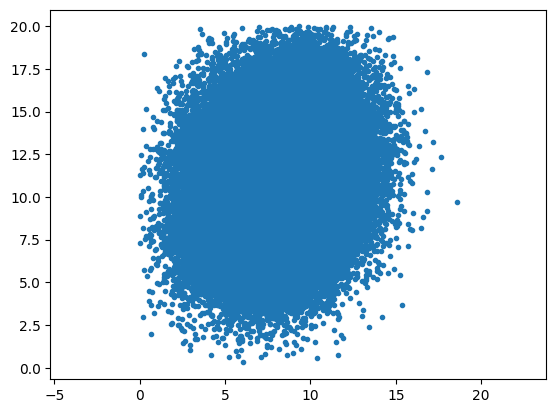

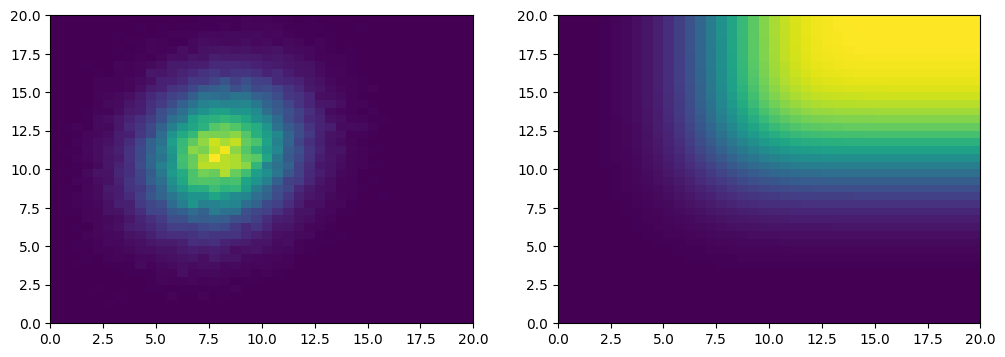

In [35]:
# TRUE DISTRIBUTION
mu = [8, 11]
sig = [[5, 1], [1, 8]] 

# generate initial samples of demand 
samples = BoundedMultivariateNormalDist(mu, sig, np.array([[0,20],[0,20]]), size=100000, rng=None)

x = samples[:,0]
y = samples[:,1]
plt.plot(x,y, '.')
plt.axis('equal')
plt.show()


# histogram and plotting

hist, xedges, yedges = np.histogram2d(x, y, bins=(40, 40), range=((0,20), (0,20)), density=True)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.pcolormesh(xedges, yedges, hist.T)

cdf = hist.cumsum(axis=0).cumsum(axis=1)*dx*dy
#print(cdf[-1,-1])

ax2.pcolormesh(xedges, yedges, cdf.T)
plt.show()



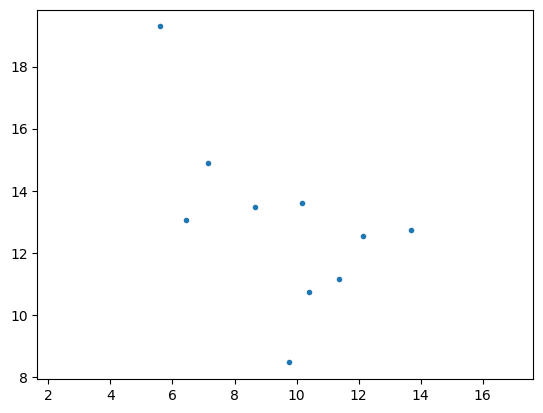

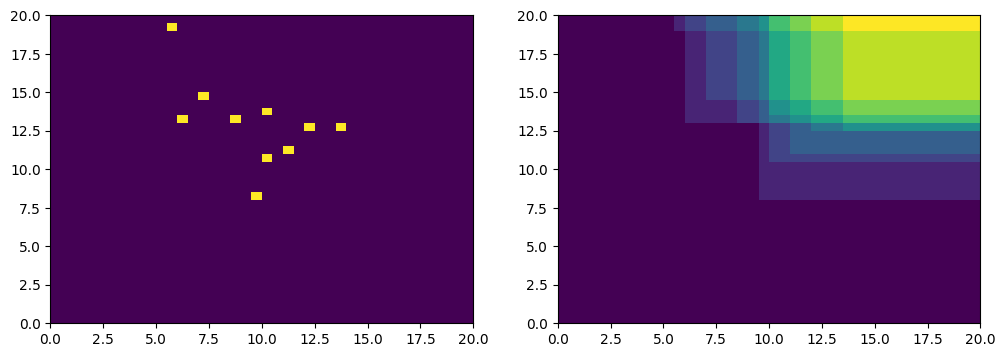

In [36]:
# Initial dataset
# generate initial samples of demand 
d_train = BoundedMultivariateNormalDist(mu, sig, np.array([[0,20],[0,20]]), size=N_off, rng=None)

x = d_train[:,0]
y = d_train[:,1]
plt.plot(x,y, '.')
plt.axis('equal')
plt.show()


# histogram and plotting

hist, xedges, yedges = np.histogram2d(x, y, bins=(40, 40), range=((0,20), (0,20)), density=True)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.pcolormesh(xedges, yedges, hist.T)

cdf = hist.cumsum(axis=0).cumsum(axis=1)*dx*dy
#print(cdf[-1,-1])

ax2.pcolormesh(xedges, yedges, cdf.T)
plt.show()


7.0710678118654755


(0.0, 20.0)

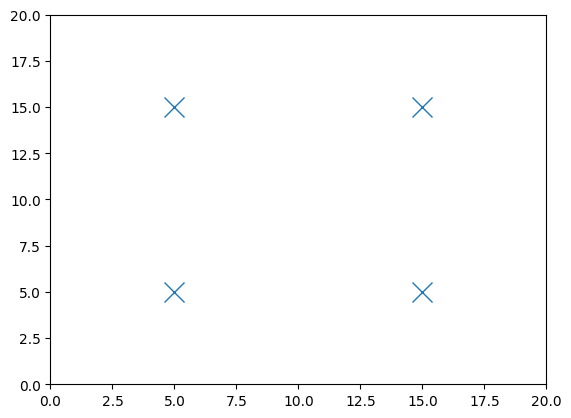

In [37]:
# defines atoms via covering
[eta, atoms] = position_points(K, 10)
print(eta)

plt.plot(atoms[:,0], atoms[:,1],"x",markersize=14,linestyle='')
plt.ylim([0,20])
plt.xlim([0,20])

(10, 2)
(4, 2)
1.0
[0.1 0.  0.4 0.5]
382.40547155355154
7.0710678118654755


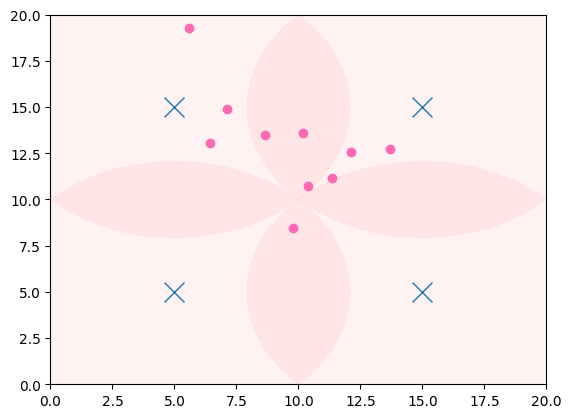

In [38]:
# define initial ambiguity set
samples_off = d_train
r2 = 0.6
alpha = 1 - r2 - 0.002
beta_0 = alpha
diam = np.sqrt(2*np.power(40,2))
#C = 1/np.sqrt(2)*3
C = np.sqrt(5)*np.power(2,3/4)*np.sqrt(1/(1-1/np.sqrt(2)) + 4/3)
weights_init, counter_init = get_initial_weights(np.array(samples_off),np.array(atoms))
radius_true_init = diam*(C*np.power(N_off,-1/5) + np.sqrt(5)*np.power(2*np.log(1/beta_0),1/4)*np.power(N_off,-1/4))
radius_init = radius_true_init + eta
print(weights_init.sum())
print(weights_init)
print(radius_init)
print(eta)

x_coords = atoms[:,0]
y_coords = atoms[:,1]
fig, ax = plt.subplots()
plt.plot(atoms[:,0], atoms[:,1],"x",markersize=14,linestyle='')
for x, y in zip(x_coords, y_coords):
    circle = plt.Circle((x, y), eta, color='r', alpha = 0.05,fill=True, linestyle="--",linewidth=0.5)
    ax.add_patch(circle)
plt.ylim([0,20])
plt.xlim([0,20])
plt.plot(samples_off[:,0],samples_off[:,1], '.',color = 'hotpink',markersize=12)

In [41]:
# set optimization routine
np.random.seed(27)
C = 2000
n=10
m=2
c = np.random.uniform(30,50,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(10,20,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)
r = np.random.uniform(20,40,n)

[problem,y,Y,st, s, gamma, lam, d_train, wk, eps] = prob_inv(K**2,m,n,c,Q,d,t,h,r)

In [43]:
# optimization routine
T_sim = 1

weights = weights_init
counter = counter_init
radius = radius_init

d_train.value = atoms.T

obj = np.empty((T_sim,1))
opt_val = np.empty((T_sim,2))
solver_time = np.empty((T_sim,1))

for t in range(T_sim):
    wk.value = weights
    eps.value = radius

    problem.solve(solver=cp.MOSEK, verbose=True)
    solver_time[t] = problem.solver_stats.solve_time
    obj[t] = problem.value
    opt_val[t] = st.value

    # new realization
    w= BoundedMultivariateNormalDist(mu, sig, np.array([[0,20],[0,20]]), size=1, rng=None)
    
    # update confidence
    #beta_next = alpha*np.power(r, t+1)
    beta_next = alpha

    # update ambiguity set
    weights_next, counter_next, radius_next = update_ambiguity(counter, N_off + (t+1), w, K, atoms, beta_next,C,diam)

    weights = weights_next
    radius = radius_next + eta
    counter = counter_next

print(weights.sum())
print(radius)
print(eta)

                                     CVXPY                                     
                             v1.5.0.dev0+0.519315d                             
(CVXPY) Jun 13 07:23:55 PM: Your problem has 1726 variables, 114 constraints, and 13 parameters.
(CVXPY) Jun 13 07:23:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 13 07:23:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 13 07:23:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 13 07:23:55 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jun 13 07:23:55 PM: Finished problem compilation (took 5.145e-03 seconds).
--------------